In [14]:
import torch
from models import mobilenetv2, resnet56
from embedl.plumbing.torch.metrics.target import Target
from embedl.torch.pruning.methods import UniformPruning
from embedl.torch.viewer import view_model
from embedl.torch.metrics.performances import Flops  
from embedl.torch.metrics.measure_performance import measure_flops
import torchvision.datasets as datasets
from embedl.torch.pruning.methods import plot_pruning_profile 
import torchvision.transforms as transforms
import torch.nn as nn
from embedl.torch.metrics.performances import Flops
from embedl.torch.pruning.methods import (
    PruningMethod,
    ChannelPruningTactic,
)
from embedl.plumbing.torch.metrics.scorers import ChannelPruningScorer, PruningBalancer
from embedl.torch.metrics.importance_scores import WeightMagnitude


normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]
)

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root="/home/jonna/data",
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                normalize,
            ]
        ),
    ),
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def validate(val_loader, model, criterion):
    """
    Run evaluation
    """

    prec1 = 0
    count = 0
    # switch to evaluate mode
    model.eval()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 += accuracy(output.data, target)[0] * target.size(0)
            # print(accuracy(output.data, target)[0])
            count += target.size(0)

    print(f" * Prec@1 {prec1/count:.3f}")
    return

Validate before pruning


100%|██████████| [02:14<00:00, 168.60s/it] (Flops) 


 * Prec@1 93.340



Validate after pruning
 * Prec@1 10.000
0.1998398491241445


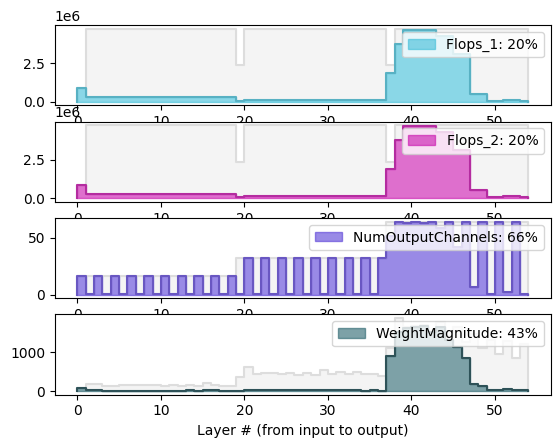

Validate before pruning


100%|██████████| [01:16<00:00, 96.24s/it] (Flops)  


 * Prec@1 93.920



Validate after pruning
 * Prec@1 10.000
0.1999814524879703


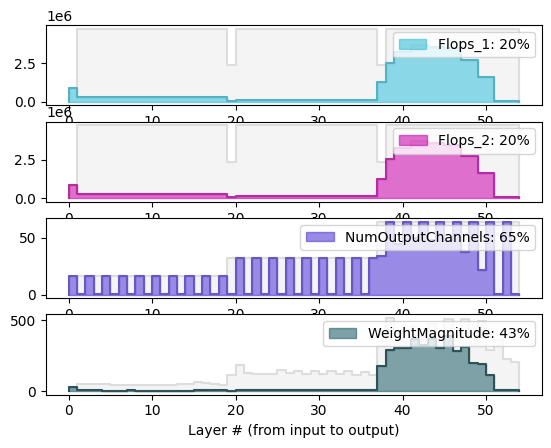

Validate before pruning


100%|██████████| [01:13<00:00, 91.74s/it] (Flops)  


 * Prec@1 93.210



Validate after pruning
 * Prec@1 10.000
0.19983580331374945


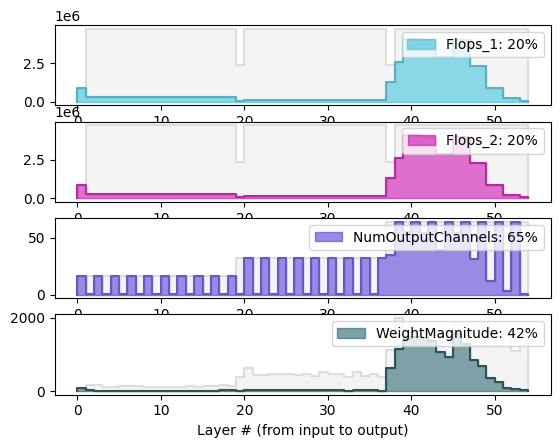

In [15]:
## resnet56_magnitude_20_lr1_wd4_1

state_dict = torch.load(
"/home/jonna/hyperparameter_sensitivity_pruning/experiments/cifar10/resnet56/base_model/results_1/lr_10**-1.00_wd_10**-4.00/checkpoint_final.th"
)["state_dict"]
state_dict = {key[7:]: weights for key, weights in state_dict.items()}
model = resnet56()
model.load_state_dict(state_dict)
model.cuda()

print("Validate before pruning")
validate(val_loader, torch.nn.DataParallel(model), nn.CrossEntropyLoss().cuda())


input_shape = [1, 3, 32, 32]
base_flops = measure_flops(model=model, input_shape=input_shape)


scorer = ChannelPruningScorer(
importance_score=WeightMagnitude(), channel_pruning_balancer=None
)
tactic = ChannelPruningTactic(step_size=1, search_depth=1, speedup_pruning=False)

pruning_method = PruningMethod(scorer, [tactic], target=Target(Flops(), fraction=0.2))
pruning_steps = pruning_method.prune(model, input_shape=input_shape)

print("\nValidate after pruning")
validate(val_loader, torch.nn.DataParallel(model), nn.CrossEntropyLoss().cuda())

pruned_flops = measure_flops(model=model, input_shape=input_shape)
print(pruned_flops / base_flops)  # 0.1998398491241445

plot_pruning_profile(model, pruning_steps)
torch.save(model, '/home/jonna/pytorch_resnet_cifar10/pruned_models/resnet56_magnitude_20_lr1_wd4_1.th' )

## resnet56_magnitude_20_lr16_wd3_0

state_dict = torch.load(
"/home/jonna/hyperparameter_sensitivity_pruning/experiments/cifar10/resnet56/base_model/extended_grid/results_0/lr_10**-1.60_wd_10**-3.00/checkpoint_final.th"
)["state_dict"]
state_dict = {key[7:]: weights for key, weights in state_dict.items()}
model = resnet56()
model.load_state_dict(state_dict)
model.cuda()

print("Validate before pruning")
validate(val_loader, torch.nn.DataParallel(model), nn.CrossEntropyLoss().cuda())


input_shape = [1, 3, 32, 32]
base_flops = measure_flops(model=model, input_shape=input_shape)


scorer = ChannelPruningScorer(
importance_score=WeightMagnitude(), channel_pruning_balancer=None
)
tactic = ChannelPruningTactic(step_size=1, search_depth=1, speedup_pruning=False)

pruning_method = PruningMethod(scorer, [tactic], target=Target(Flops(), fraction=0.2))
pruning_steps = pruning_method.prune(model, input_shape=input_shape)

print("\nValidate after pruning")
validate(val_loader, torch.nn.DataParallel(model), nn.CrossEntropyLoss().cuda())

pruned_flops = measure_flops(model=model, input_shape=input_shape)
print(pruned_flops / base_flops)  # 0.1998398491241445

plot_pruning_profile(model, pruning_steps)
torch.save(model, '/home/jonna/pytorch_resnet_cifar10/pruned_models/resnet56_magnitude_20_lr16_wd3_0.th' )

## resnet56_magnitude_20_lr1_wd4_0

state_dict = torch.load(
"/home/jonna/hyperparameter_sensitivity_pruning/experiments/cifar10/resnet56/base_model/results_0/lr_10**-1.00_wd_10**-4.00/checkpoint_final.th"
)["state_dict"]
state_dict = {key[7:]: weights for key, weights in state_dict.items()}
model = resnet56()
model.load_state_dict(state_dict)
model.cuda()

print("Validate before pruning")
validate(val_loader, torch.nn.DataParallel(model), nn.CrossEntropyLoss().cuda())


input_shape = [1, 3, 32, 32]
base_flops = measure_flops(model=model, input_shape=input_shape)


scorer = ChannelPruningScorer(
importance_score=WeightMagnitude(), channel_pruning_balancer=None
)
tactic = ChannelPruningTactic(step_size=1, search_depth=1, speedup_pruning=False)

pruning_method = PruningMethod(scorer, [tactic], target=Target(Flops(), fraction=0.2))
pruning_steps = pruning_method.prune(model, input_shape=input_shape)

print("\nValidate after pruning")
validate(val_loader, torch.nn.DataParallel(model), nn.CrossEntropyLoss().cuda())

pruned_flops = measure_flops(model=model, input_shape=input_shape)
print(pruned_flops / base_flops)  # 0.1998398491241445

plot_pruning_profile(model, pruning_steps)
torch.save(model, '/home/jonna/pytorch_resnet_cifar10/pruned_models/resnet56_magnitude_20_lr1_wd4_0.th' )